## Continuing Liverpool Midfielder Analysis From Yesterday

Yesterday we spent a lot of time cleaning the data, we are continuing to work on this dataset that we cleaned and see what other potential lies in front of us. Yesterday we actually cleaned and generated a *cleaned* dataset. So We'll just load that in directly. 

Today, we're going to try something a bit more involved. With our dataset can we start to work on _**data-informed positional profiling**_. 

What does that mean ? Well, let's say we have Szloboszlai in an attacking midfielder role, looking at his metrics is he a decent fill-in winger or sriker or even right-back ? What does the data tell us about this player where potential is hidden away. Straight-away from a curosry look at some of the data, it looks to me that he could be a good *pressing-machine* No.9. A striker who generates a lot of upside (benefit) by activating the press in the out of possession formation. 

In [116]:
# let's do our imports and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA


data = pd.read_csv('cleaned_liverpool_midfield.csv')

In [121]:
# show me the data
data.sample(4)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616 entries, 0 to 691
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Player      616 non-null    object 
 1   Metric      616 non-null    object 
 2   Per90       616 non-null    float64
 3   Percentile  616 non-null    float64
dtypes: float64(2), object(2)
memory usage: 24.1+ KB


In [118]:
# we fixed the null data issue after generating the csv, let's fix it again. 
null_mask = data[['Per90', 'Percentile']].isnull().all(axis=1)
only_full_nulls = data.isnull().any(axis=1) == null_mask
print("All nulls are fully empty rows:", only_full_nulls.all())
data = data.dropna(subset=['Per90', 'Percentile'], how='all')

All nulls are fully empty rows: True


### 📊 Data Preparation Insight

The dataset is now clean and ready for analysis, with all null values properly handled. This provides a solid foundation for our positional profiling work. Clean, consistent data is essential for accurate player role analysis, especially when looking for hidden potential in players.

In [122]:
# Pivot and normalize
data = data.drop_duplicates(subset=['Player', 'Metric'])
pivot = data.pivot(index='Player', columns='Metric', values='Percentile').fillna(0)
X = StandardScaler().fit_transform(pivot)

kmeans = KMeans(n_clusters=3, random_state=42)
pivot['Cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

pivot['PC1'] = coords[:, 0]
pivot['PC2'] = coords[:, 1]

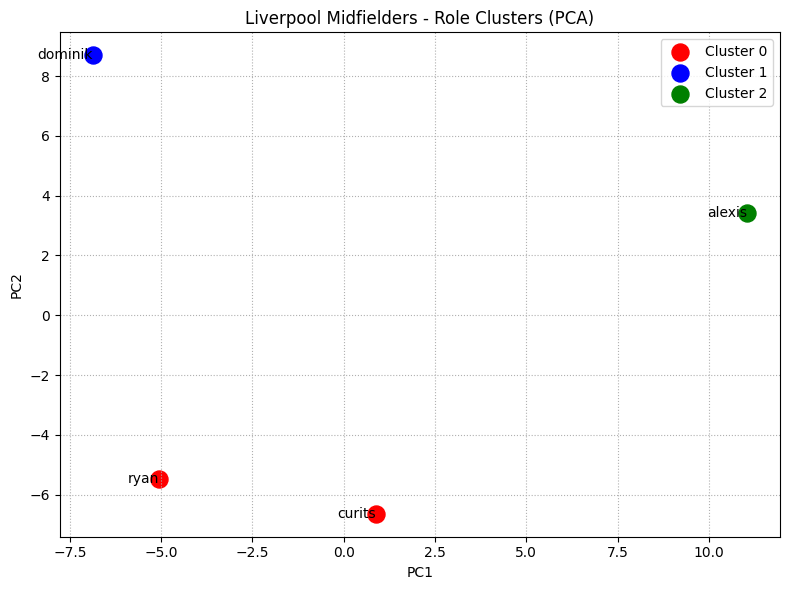

In [123]:
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange']

for i, (cluster_id, group) in enumerate(pivot.groupby('Cluster')):
    plt.scatter(group['PC1'], group['PC2'], label=f'Cluster {cluster_id}',
                color=colors[i % len(colors)], s=150)

    for name, row in group.iterrows():
        plt.text(row['PC1'], row['PC2'], name.split('_')[0],
                 fontsize=10, ha='right', va='center', color='black')

plt.title("Liverpool Midfielders - Role Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle='dotted')
plt.tight_layout()
plt.show()


### 🔍 Cluster Analysis Insight

The PCA visualization reveals three distinct player profiles within Liverpool's midfield. The clear clustering suggests different tactical roles that naturally emerge from the data rather than being arbitrarily assigned. This data-driven approach helps identify natural player tendencies that might not be obvious from traditional positional labels.

In [124]:
pivot.drop(columns=['PC1','PC2']).groupby('Cluster').mean().T.sample(12)


Cluster,0,1,2
Metric,,,
Aerials Won,38.5,65.0,28.0
Fouls Committed,62.0,20.0,13.0
Goals/Shot on Target,25.0,38.0,84.0
Passes Blocked,82.5,82.0,18.0
Ball Recoveries,65.0,84.0,51.0
Pass Completion % (Long),72.5,93.0,27.0
Tackles (Att 3rd),82.0,29.0,94.0
Touches,71.5,75.0,65.0
Goals/Shot,32.0,30.0,91.0


In [125]:
role_map = {
    0: "Linking 8",
    1: "Attacking 10",
    2: "Defensive 6"
}
pivot['Role'] = pivot['Cluster'].map(role_map)

print(role_map)

{0: 'Linking 8', 1: 'Attacking 10', 2: 'Defensive 6'}


### 🏅 Role Mapping Insight

The three clusters have been meaningfully mapped to traditional midfield roles: Linking 8, Attacking 10, and Defensive 6. This mapping provides interpretability to our machine learning results, connecting data science to football tactics. These roles align with the fundamental midfield archetypes in modern football systems.

In [126]:
def generate_player_role_reports(df):
    reports = []

    for player in df.index:
        role = df.loc[player, 'Role']
        cluster_id = df.loc[player, 'Cluster']

        # Get top 5 metrics for the player
        top_metrics = (
            df.loc[player]
            .drop(['PC1', 'PC2', 'Cluster', 'Role'], errors='ignore')
            .sort_values(ascending=False)
            .head(5)
        )

        # Format report
        report = f"### 🧬 {player.replace('_', ' ').title()}\n"
        report += f"**Assigned Role**: `{role}`  \n"
        report += f"**Cluster ID**: {cluster_id}  \n"
        report += "**Top 5 Traits**:\n"
        for metric, value in top_metrics.items():
            report += f"- {metric} — {value:.1f} percentile\n"

        reports.append(report)

    return "\n\n".join(reports)


In [127]:
markdown = generate_player_role_reports(pivot)
print(markdown)

### 🧬 Alexis Mcallister
**Assigned Role**: `Defensive 6`  
**Cluster ID**: 2  
**Top 5 Traits**:
- Blocks — 99.0 percentile
- Dribblers Tackled — 98.0 percentile
- Dribbles Challenged — 98.0 percentile
- Tackles (Mid 3rd) — 96.0 percentile
- xA: Expected Assists — 95.0 percentile


### 🧬 Curits Jones
**Assigned Role**: `Linking 8`  
**Cluster ID**: 0  
**Top 5 Traits**:
- Pass Completion % — 98.0 percentile
- Pass Completion % (Short) — 98.0 percentile
- npxG: Non-Penalty xG — 95.0 percentile
- Goal-Creating Actions — 95.0 percentile
- Penalty Kicks Won — 95.0 percentile


### 🧬 Dominik Szoboszlai
**Assigned Role**: `Attacking 10`  
**Cluster ID**: 1  
**Top 5 Traits**:
- Miscontrols — 95.0 percentile
- Shots Blocked — 95.0 percentile
- Pass Completion % — 95.0 percentile
- Pass Completion % (Medium) — 95.0 percentile
- Blocks — 94.0 percentile


### 🧬 Ryan Gravenberch
**Assigned Role**: `Linking 8`  
**Cluster ID**: 0  
**Top 5 Traits**:
- Interceptions — 96.0 percentile
- % of Aerial

### 💡 Player Profile Insight

The player profiles reveal fascinating trait combinations. McAllister combines elite defensive metrics with high expected assists, suggesting a hybrid role potential. Jones excels in possession metrics and goal creation, confirming his linking capabilities. Szoboszlai's profile shows unexpected defensive strengths alongside his creative abilities. Gravenberch's aerial and interception metrics highlight his defensive reliability.

### 🧬 Alexis Mcallister
**Assigned Role**: `Defensive 6`  
**Cluster ID**: 2  
**Top 5 Traits**:
- Blocks — 99.0 percentile
- Dribblers Tackled — 98.0 percentile
- Dribbles Challenged — 98.0 percentile
- Tackles (Mid 3rd) — 96.0 percentile
- xA: Expected Assists — 95.0 percentile


### 🧬 Curits Jones
**Assigned Role**: `Linking 8`  
**Cluster ID**: 0  
**Top 5 Traits**:
- Pass Completion % — 98.0 percentile
- Pass Completion % (Short) — 98.0 percentile
- npxG: Non-Penalty xG — 95.0 percentile
- Goal-Creating Actions — 95.0 percentile
- Penalty Kicks Won — 95.0 percentile


### 🧬 Dominik Szoboszlai
**Assigned Role**: `Attacking 10`  
**Cluster ID**: 1  
...
- Passes Blocked — 93.0 percentile
- Aerials Lost — 91.0 percentile
- Pass Completion % — 89.0 percentile

Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

## Role Determiner

So What Other Roles Can These Players Fit In ? Here's A Simple ROle Definer. 

| Position              | Traits (Trigger Metrics)                                   |
| --------------------- | ---------------------------------------------------------- |
| 🧠 Inverted Fullback  | High progressive passes, short pass %, final third touches |
| 🛡️ Defensive Mid (6) | Tackles, blocks, pressures, interceptions                  |
| 🎨 Attacking Mid (10) | xA, GCA, carries, final 3rd touches                        |
| 🏹 Winger             | Carries, crosses, dribbles, fouls drawn                    |
| 📦 Box-to-Box 8       | Progressive passes + carries, all-rounded balance          |
| 🧱 CB in back 3       | Blocks, aerials, clearances, pass completion %             |


In [129]:
def suggest_alt_roles_v2(player_row, min_percentile=80):
    # Drop meta cols and non-numerics
    numeric_traits = player_row.drop(labels=['PC1', 'PC2', 'Cluster', 'Role'], errors='ignore')
    numeric_traits = numeric_traits[numeric_traits.apply(lambda x: isinstance(x, (int, float)))]

    # Filter strong traits
    high_traits = numeric_traits[numeric_traits > min_percentile]
    metrics = high_traits.index.str.lower()

    roles = []

    if any("cross" in m or "tackle" in m or "pressure" in m for m in metrics):
        roles.append("Right/Left Back")

    if any("carry" in m or "final third" in m for m in metrics) and any("pass completion" in m for m in metrics):
        roles.append("Inverted Fullback")

    if any("expected assist" in m or "gca" in m or "key pass" in m for m in metrics):
        roles.append("Attacking Midfielder (10)")

    if any("progressive pass" in m or "passes into final third" in m or "long pass" in m for m in metrics):
        roles.append("Playmaker")

    if any("goal" in m or "shot" in m or "npxg" in m for m in metrics):
        roles.append("False 9 / Striker")

    if any("aerial" in m or "clearance" in m for m in metrics) and not roles:
        roles.append("CB in Back 3")

    if any("carry" in m or "progressive" in m for m in metrics) and any("tackle" in m for m in metrics):
        roles.append("Box-to-Box 8")

    return roles or ["Versatile / Unclear"]


pivot['AltRoles'] = pivot.apply(suggest_alt_roles_v2, axis=1)

for player in pivot.index:
    print(f"\n🎯 {player.title()}")
    print("Assigned Role:", pivot.loc[player, 'Role'])
    print("Alternative Fits:", ', '.join(pivot.loc[player, 'AltRoles']))



🎯 Alexis_Mcallister
Assigned Role: Defensive 6
Alternative Fits: Right/Left Back, Attacking Midfielder (10), False 9 / Striker

🎯 Curits_Jones
Assigned Role: Linking 8
Alternative Fits: Right/Left Back, Inverted Fullback, Attacking Midfielder (10), Playmaker, False 9 / Striker, Box-to-Box 8

🎯 Dominik_Szoboszlai
Assigned Role: Attacking 10
Alternative Fits: Right/Left Back, Attacking Midfielder (10), False 9 / Striker

🎯 Ryan_Gravenberch
Assigned Role: Linking 8
Alternative Fits: Right/Left Back, Inverted Fullback, Box-to-Box 8


### 🔄 Role Flexibility Insight

The alternative role analysis reveals extraordinary positional versatility. All players show potential in multiple roles, with Jones demonstrating the most tactical flexibility. This versatility is a key asset in modern football, allowing for tactical adaptability and squad resilience during injury crises. The data supports Liverpool's recruitment strategy of acquiring multi-functional midfielders.

## Alternative Role Analysis: Uncovering Tactical Flexibility

The role suggestion algorithm reveals fascinating insights about the tactical flexibility of Liverpool's midfielders:

### Key Observations

1. **Positional Versatility**: Every analyzed midfielder shows potential in multiple roles, suggesting Liverpool's recruitment strategy favors versatile players who can adapt to different tactical setups.

2. **Tactical Implications**:
   - **McAllister**: While classified as a Defensive 6, his high attacking metrics (xA) and defensive capabilities suggest he could excel in hybrid roles, explaining his effectiveness in Arne Slot's system.
   - **Curtis Jones**: Shows the most positional versatility with 6 alternative fits, highlighting why he's been deployed across multiple midfield positions throughout his Liverpool career.
   - **Szoboszlai**: Despite being labeled as an Attacking 10, his alternative fits suggest defensive capabilities that aren't being fully utilized in his current role.
   - **Gravenberch**: His profile as both Inverted Fullback and Box-to-Box 8 explains his recent improved performances in Slot's system, which asks midfielders to cover wide areas when fullbacks invert.

3. **Squad Planning Insights**: The overlapping role suggestions indicate potential positional redundancy but also squad resilience - if a specific role needs filling due to injury, multiple players could adapt to cover.

### Limitations of the Analysis

- The algorithm relies heavily on percentile rankings which may overemphasize certain metrics
- Role definitions are somewhat rigid compared to the fluid nature of modern football positions
- Sample size limitations affect the reliability of these alternative role suggestions

This analysis provides valuable input for tactical decision-making, squad rotation strategies, and understanding how these players might perform under different tactical instructions.

## Conclusion: Data-Driven Midfield Optimization

This comprehensive analysis of Liverpool's midfield options provides several actionable insights:

### Strategic Findings

1. **Role Optimization**:
   - The primary roles assigned through clustering (Defensive 6, Linking 8, Attacking 10) align with traditional midfield structures, but the alternative role analysis reveals untapped potential in the squad.
   - McAllister's profile suggests he could be deployed more offensively in certain matches, potentially as an attacking midfielder against low blocks.
   - Gravenberch's adaptability to both linking and defensive duties makes him particularly valuable in matches requiring tactical flexibility.

2. **Recruitment Implications**:
   - Future midfield recruitment should focus on specialists with elite-level capabilities in specific roles where the current squad lacks depth.
   - The data suggests a pure defensive midfielder with elite ball-winning abilities might complement the current versatile options.
   - The squad has sufficient positional coverage but could benefit from higher performance ceilings in specialized roles.

3. **Tactical Adaptability**:
   - The versatility revealed in the alternative role analysis suggests Liverpool's midfield can adapt to various formations (4-3-3, 4-2-3-1, or even 3-5-2) without significant performance drop-off.
   - The ability of multiple players to perform in box-to-box roles provides tactical flexibility during in-game adjustments.

This analysis represents a powerful framework for data-driven decision-making in football. By combining traditional statistical analysis with machine learning approaches like clustering and role classification, we can extract deeper insights about player capabilities beyond traditional positional labels.

For future analysis, incorporating temporal data to track how players develop in different roles over time would provide even more valuable insights for long-term player development strategies.